## In this tutorial, you are going to etimate the linear filters K and the nonlinear function $f(\cdot)$ based on the simulated data from a linear-nonlinear-Poisson model neuron. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
%matplotlib notebook

In [2]:
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.labelcolor': '0', 'text.color':'0', 'xtick.color':'0', 'ytick.color':'0'}),

SMALL_SIZE = 12
MEDIUM_SIZE = 21
BIGGER_SIZE = 21

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Let's simulating a linear-nonlinear-Poisson model neuron

In [3]:
class LNP_neuron:
    def __init__(self, K):
        # K: size m x D; denotes m linear filters with D dimensions
        self.K = K
        self.dt = 0.1
        
    def spk(self, x):
        # x: size D x T; denotes stimulus 
        fil_x = self.K@x
        
        # define nonlinear function f(.)
        output = np.zeros_like(fil_x)
        
        for i in range(output.shape[0]):
            output[i,:] = self.i_o(fil_x[i,:]) 
        spk = np.random.poisson(np.sum(output,0)*self.dt)
        
        return spk
    
    def i_o(self, inp):
        tmp = np.maximum(inp,0) 
        outp = tmp**3
        
        return outp
        
    def plot_i_o(self):
        #plot input_output function
        f,a = plt.subplots(figsize=(5,4))
        x = np.linspace(-5,5,100)
        y = self.i_o(x)
        plt.plot(x, y)
        plt.xlabel('input')
        plt.ylabel('output')
        plt.title('$f(\cdot)$')
        plt.tight_layout()
        return f,a


<IPython.core.display.Javascript object>


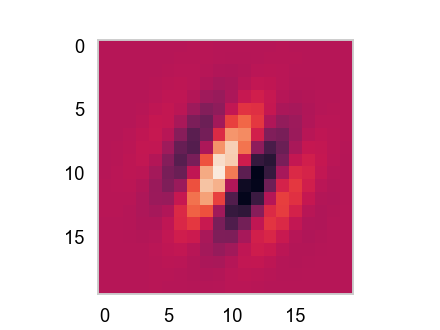

<IPython.core.display.Javascript object>


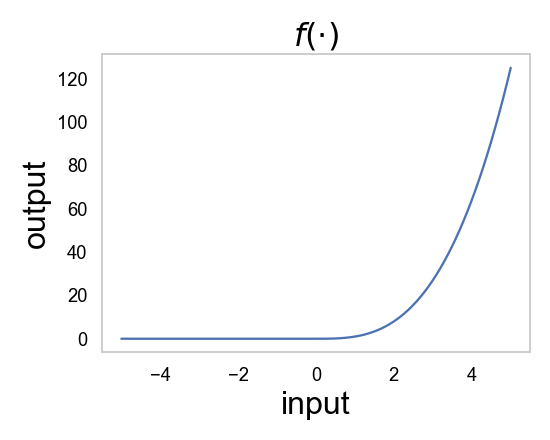

<IPython.core.display.Javascript object>


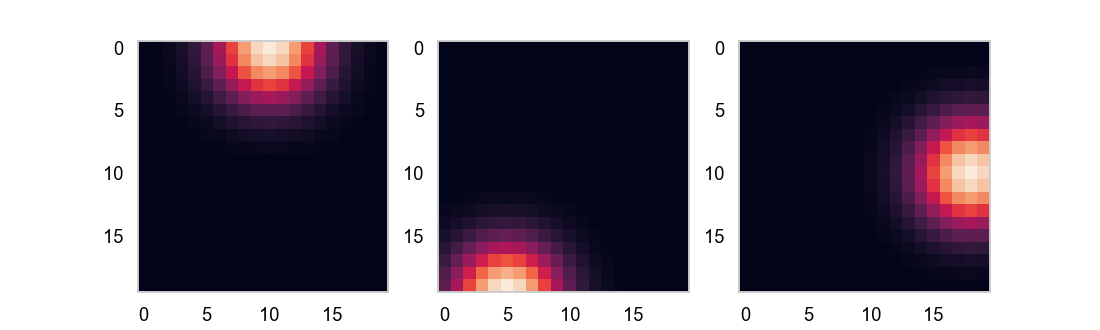

In [4]:
# neuron 1 with 1 linear filter
K1 = np.zeros((20,20,1))
for i in range(20):
    for j in range(20):
        K1[i,j,0] = np.cos(i*np.cos(np.pi/3)+j*np.sin(np.pi/3))

tmp = np.arange(20)
K1[:,:,0] = K1[:,:,0]*(norm.pdf(tmp, loc=10, scale=3)[:, np.newaxis]@norm.pdf(tmp, loc=10, scale=3)[np.newaxis,:])   
K1[:,:,0] = K1[:,:,0]/np.linalg.norm(K1[:,:,0])
        
plt.figure(figsize=(4,3))
plt.imshow(K1[:,:,0])

K1_flat = K1.reshape((-1,1), order='F')

neu1 = LNP_neuron(K1_flat.T)
f0,a0 = neu1.plot_i_o()

# neuron 2 with 3 linear filter
K2 = np.zeros((20,20,3))
f,a = plt.subplots(1,3, figsize=(10,3))

centers = [[0,10], [20,5], [10,18]]
tmp = np.arange(20)

for ii in range(3):
    center = centers[ii]
    K2[:,:,ii] = norm.pdf(tmp, loc=center[0], scale=3)[:, np.newaxis]@norm.pdf(tmp, loc=center[1], scale=3)[np.newaxis,:]
    K2[:,:,ii] = K2[:,:,ii]/np.linalg.norm(K2[:,:,ii])
    a[ii].imshow(K2[:,:,ii])

K2_flat = K2.reshape((-1,3), order='F')

neu2 = LNP_neuron(K2_flat.T)


## Let's generate spike trains with Gaussian white stimulus

In [5]:
# generate Gaussian white stimulus with 400 dimensions and 1e5 timepoints
x = np.random.normal(size=(400, 100000))
spk1 = neu1.spk(x)
spk2 = neu2.spk(x)
print(sum(spk1))
print(sum(spk2))

7919
23888


## Can you identify linear filter K based on the simulated data?
## Let's plot spike-triggered average

<IPython.core.display.Javascript object>


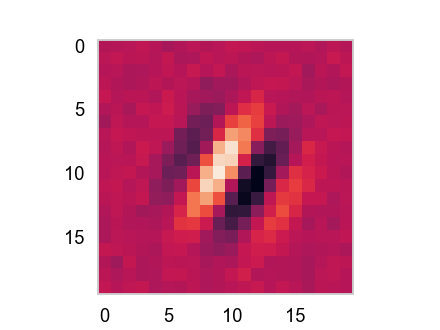

In [6]:
STA1 = np.sum(x*spk1[np.newaxis,:],1)/np.sum(spk1)
K1_est = STA1.reshape((20,20),order='F')
plt.figure(figsize=(4,3))
plt.imshow(K1_est)

<IPython.core.display.Javascript object>


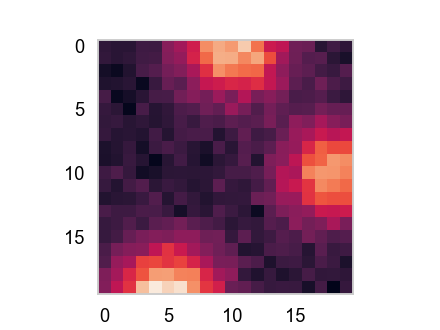

In [7]:
STA2 = np.sum(x*spk2[np.newaxis,:],1)/np.sum(spk2)
K2_est = STA2.reshape((20,20),order='F')
plt.figure(figsize=(4,3))
plt.imshow(K2_est)

## Let's plot the eigenspectrum of spike-triggered covariance


In [8]:
STC2 = (x-STA2[:,np.newaxis])@((x-STA2[:,np.newaxis])*spk2[np.newaxis,:]).T/np.sum(spk2)

In [39]:
eigval, eigvec = np.linalg.eigh(STC2)
#eigval, eigvec = np.linalg.eigh(STC2 + STA2[:, np.newaxis]@STA2[np.newaxis,:] - np.eye(400))

In [40]:
#eigval0, junk = np.linalg.eigh(x@x.T/x.shape[1])

<IPython.core.display.Javascript object>


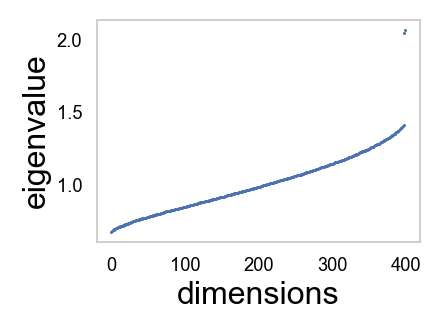

In [41]:
plt.figure(figsize=(4,3))
plt.plot(eigval,'o', markersize = 1)
plt.xlabel('dimensions')
plt.ylabel('eigenvalue')
plt.tight_layout()
#plt.plot(eigval0,'ko', markersize=1)
#plt.hist(eigval)

<IPython.core.display.Javascript object>


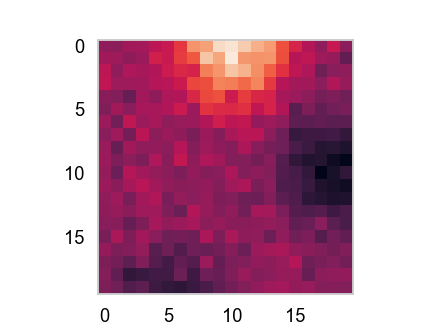

In [24]:
K2_est_STC = eigvec[:,-2].reshape((20,20),order='F')
plt.figure(figsize=(4,3))
plt.imshow(K2_est_STC)

## Can you identify $f(\cdot)$ based on the simulated data?

In [13]:
#for neuron 1 with 1 filter
k1 = STA1/np.linalg.norm(STA1)
k1x = k1@x

max_spk = np.max(spk1)
k1x_spk = k1@(x[:,spk1==1])

for n_spk in range(2, max_spk+1):
    tmp = k1@(x[:,spk1==n_spk])
    k1x_spk = np.concatenate((k1x_spk,np.repeat(tmp, n_spk)))


<IPython.core.display.Javascript object>


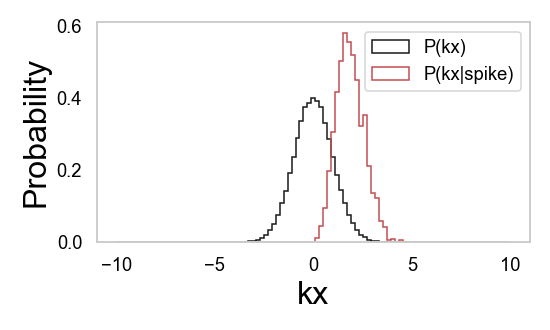

<IPython.core.display.Javascript object>


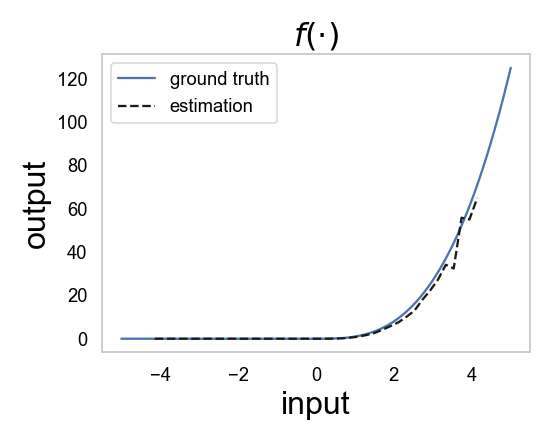

C:\Users\xiaji\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [14]:
plt.figure(figsize=(5,3))
bins = np.linspace(-10,10,100)
a = plt.hist(k1x, bins, histtype='step', color = 'k', density=1)
b = plt.hist(k1x_spk, bins, histtype='step', color = 'r', density=1)
plt.ylabel('Probability')
plt.xlabel('kx')
plt.legend(['P(kx)', 'P(kx|spike)'])
plt.tight_layout()

p_spk = np.mean(spk1)

f,ax = neu1.plot_i_o() 
ax.plot(a[1][1:], b[0]/a[0]*p_spk/neu1.dt,'k--')
ax.legend(['ground truth','estimation'])
plt.show()